In [1]:
import os
import torch
import pandas as pd
import os
from pathlib import Path
import pandas as pd
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import numpy as np

from config import *
from labels import label_lookups
from Inference.inference_lookup import inference_lookup_cnn
from src.model_densenet_vectoroutput import d169_3d
from src.seed import seed_everything
from src.testing_vectoroutput import test_epoch_vectoroutput
from src.utils import Logger

seed_everything(random_state)

/home/yhchoi/SSPreprocess/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# All labels
lllll = [
# Unwanted labels
# 'Lateral-Ventricle',  
# 'Inf-Lat-Vent',
# '3rd-Ventricle',
# '4th-Ventricle',
# 'CSF',
  
# Cerebellum
['Cerebellum-White-Matter',
'Cerebellum-Cortex'],

# Medial Temporal Lobe
['Hippocampus',
 'parahippocampal',
 'entorhinal'],

# Amygdala
['Amygdala'],

# Thalamus
['Thalamus-Proper'],

# Ventral Dienchephalon
['VentralDC'],

# Choroid Plexus
['Choroid-plexus'],

# Basal Ganglia
['Accumbens-area',
 'Caudate',
 'Putamen',
 'Pallidum'
],

# Brain Stem
['Brain-Stem'],

# Frontal Lobe
['caudalmiddlefrontal',
'lateralorbitofrontal',
'medialorbitofrontal',
'rostralmiddlefrontal',
'superiorfrontal',
'parsorbitalis',
'parsopercularis',
'parstriangularis',
'precentral'],

# Occipital Lobe
['cuneus',
'lateraloccipital',
'pericalcarine',
'lingual'
],

# Temporal Lobe
['fusiform',
'inferiortemporal', 
'middletemporal',
'superiortemporal',
'transversetemporal'],

# Parietal Lobe
['paracentral',
 'postcentral',
 'inferiorparietal',
 'precuneus',
 'superiorparietal',
 'supramarginal'],

# Cortical Limbic System
['caudalanteriorcingulate',
 'rostralanteriorcingulate',
 'isthmuscingulate',
 'posteriorcingulate'
],

# Insular Cortex
['insula']
]

size_featvecs_all = [3328 * len(sublist) if sublist != ['Brain-Stem'] else 1664 for sublist in lllll]

featurenames_all = [
    'Cerebellum', 
    'Medial Temporal Lobe',
    'Amygdala',
    'Thalamus',
    'Ventral Diencephalon',
    'Choroid Plexus',
    'Basal Ganglia',
    'Brain Stem',
    'Frontal Lobe',
    'Occipital Lobe',
    'Temporal Lobe',
    'Parietal Lobe',
    'Cortical Limbic System',
    'Insular Cortex',
]

clinical_featnames_all = torch.load('/home/yhchoi/FSTrain_0205/samplevectors_internal/feature_names.pt')

################  '0:Cerebellum',       '1:Medial Temporal Lobe',   '2:Amygdala',                   '3:Thalamus',       '4:Ventral Dienchephalon', 
################  '5:Choroid Plexus',   '6:Basal Ganglia',          '7:Brain Stem',                 '8:Frontal Lobe',   '9:Occipital Lobe', 
################  '10:Temporal Lobe',   '11:Parietal Lobe',         '12:Cortical Limbic System',    '13:Insular Cortex'
parts_to_select_mri_dict = {
    0: [1, 3, 4, 5, 6, 8, 9, 10, 11, 12],
    1: [0, 3, 4, 6, 7, 9, 10, 11, 12, 13],
    2: [1, 2, 3, 5, 6, 8, 9, 11, 12, 13],
    3: [0, 1, 2, 3, 4, 5, 7, 9, 10, 13]
}

parts_to_select_clinical_dict = {
    0: [63, 61, 22, 2, 46, 64, 65, 21, 29, 0, 20, 67, 62, 27, 49, 66, 25, 1, 54, 59, 4, 57, 28, 30, 24, 34, 26, 8, 16, 5],
    1: [67, 66, 62, 61, 46, 33, 1, 31, 21, 32, 49, 16, 64, 43, 17, 38, 27, 20, 0, 26, 5, 53, 24, 29, 10, 30, 4, 63, 28, 12],
    2: [63, 46, 1, 62, 0, 20, 61, 2, 32, 26, 29, 5, 65, 56, 30, 66, 49, 53, 31, 64, 67, 24, 28, 60, 15, 9, 48, 52, 13, 21],
    3: [49, 0, 2, 67, 31, 46, 26, 61, 1, 62, 27, 32, 29, 64, 22, 4, 33, 63, 58, 52, 30, 5, 48, 66, 20, 39, 53, 43, 65, 56]
}

In [3]:
class FCN(nn.Module):
    def __init__(self, input_size):
        super(FCN, self).__init__()
        self.fc1 = nn.Linear(input_size, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 128)
        self.fc5 = nn.Linear(128, 2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = self.fc5(x)
        return x

# class FCN(nn.Module):
#     def __init__(self, input_size):
#         super(FCN, self).__init__()
#         self.fc1 = nn.Linear(input_size, 512)
#         self.fc2 = nn.Linear(512, 2)

#     def forward(self, x):
#         x = torch.relu(self.fc1(x))
#         x = self.fc2(x)
#         return x

# # Create an instance of the FCN with input size 16640
# input_size = feat_vecs.shape[1]
# fcn_model = FCN(input_size)

# # Print the model architecture
# print(fcn_model)

In [91]:
pathogen = 0
num_epochs = 1000
patience = 100
eval_start_epoch = 30
min_delta = 0.00005
lr = 0.0000005
weight_decay = 0.1
momentum = 0.999 # Only for SGD
random_state = 7970 #770 as default 7270 : viral best
batch_size = 32
mri = 1
clinical = 1
clinical_selection = True
device = 'cuda:1'
optimizer_type = 'AdamW'
earlystop_criterion = 'AUROC' # 'AUROC' or 'F1' or if else, 'loss' 
youden = False
save = 0

################  '0:Cerebellum',       '1:Medial Temporal Lobe',   '2:Amygdala',                   '3:Thalamus',       '4:Ventral Dienchephalon', 
################  '5:Choroid Plexus',   '6:Basal Ganglia',          '7:Brain Stem',                 '8:Frontal Lobe',   '9:Occipital Lobe', 
################  '10:Temporal Lobe',   '11:Parietal Lobe',         '12:Cortical Limbic System',    '13:Insular Cortex'
parts_to_select = parts_to_select_mri_dict[pathogen]
# parts_to_select = [0, 2, 3, 5, 6, 7, 9, 10, 12, 13]
ext = 1 # bool
brainpart_names = []
for part in parts_to_select:
    brainpart_names += lllll[part]
if mri:
    print(f'Num. Brainparts = {len(brainpart_names)}')

# clinical_features = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
#                      20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37,
#                      38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56,
#                      57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67]
# clinical_features = [49, 0, 2, 67, 46, 61, 27, 31, 33, 32, 1, 22, 64, 16, 63, 29, 66, 26, 4, 21, 5, 34, 14, 28, 20, 62, 17, 30, 43, 25]
clinical_features = parts_to_select_clinical_dict[pathogen]
if clinical and clinical_selection:
    print(f'Num. Clinical Features = {len(clinical_features)}')
# clinical_features = [0, 49, 46, 63, 67, 64, 22]

Num. Brainparts = 38
Num. Clinical Features = 30


Epoch 130, Pathogen 0:  13%|█▎        | 130/1000 [00:08<00:55, 15.74it/s, Best AUROC=1]


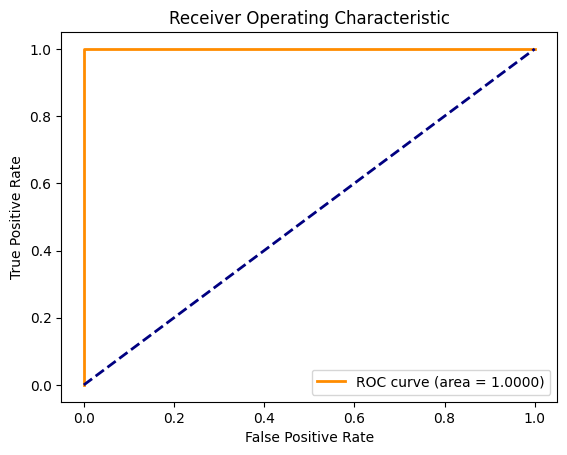

Validation loss: 0.7062016725540161, AUROC: 1.0, Accuracy: 1.0, Precision: 1.0, Recall: 1.0, F1: 1.0, AUPRC: 1.0


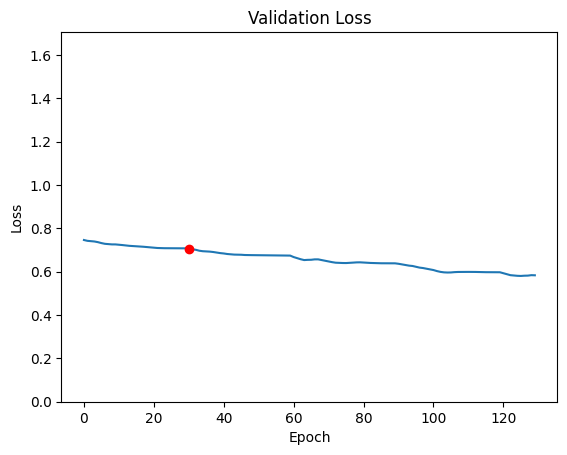

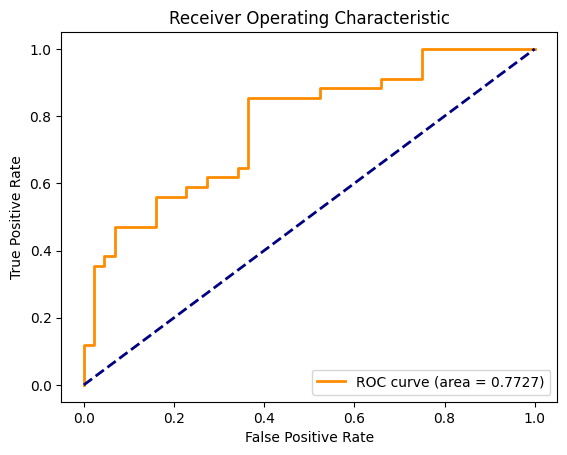

Validation loss: 0.6953002611796061, AUROC: 0.7727272727272727, Accuracy: 0.7307692307692307, Precision: 0.6444444444444445, Recall: 0.8529411764705882, F1: 0.7341772151898734, AUPRC: 0.7513945327444869


In [92]:
from sklearn.metrics import precision_score, recall_score, f1_score, average_precision_score, roc_auc_score, roc_curve, auc
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
import pandas as pd
import gc
from src.utils import AverageMeter, calculate_accuracy
import torch
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from tqdm import tqdm
from torchsampler import ImbalancedDatasetSampler

def calculate_f1_precision_recall(all_labels, predicted):
    # True positives, false positives, true negatives, false negatives 초기화
    tp = fp = tn = fn = 0

    for true, pred in zip(all_labels, predicted):
        if true == 1:
            if pred == 1:
                tp += 1
            else:
                fn += 1
        else:
            if pred == 1:
                fp += 1
            else:
                tn += 1

    # 정밀도와 재현율 계산
    precision = tp / (tp + fp) if tp + fp > 0 else 0
    recall = tp / (tp + fn) if tp + fn > 0 else 0

    if precision + recall > 0:
        f1 = 2 * (precision * recall) / (precision + recall)
    else:
        f1 = 0

    return f1, precision, recall

def validate(model, dataloader, criterion, threshold=None, youden = True):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    total_samples = 0
    all_labels = []
    all_probs = []

    with torch.no_grad():  # Disable gradient tracking during validation
        for inputs, labels in dataloader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            total_samples += labels.size(0)

            # Convert outputs to probabilities using softmax
            probs = torch.softmax(outputs, dim=1)
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
        
        all_labels = np.array(all_labels)
        all_labels = np.nan_to_num(all_labels)
        all_probs = np.array(all_probs)
        all_probs = np.nan_to_num(all_probs)

        y_pred = np.argmax(all_probs, axis=1)
        pred_probs = all_probs[:, 1]
        fpr, tpr, thresholds = roc_curve(all_labels, pred_probs)
        auroc = auc(fpr, tpr)


        threshold = find_optimal_threshold(fpr, tpr, thresholds)
        

        predicted = (pred_probs >= threshold).astype(int)

        # Calculate accuracy
        accuracy = (predicted == all_labels).sum() / len(all_labels)

        # Calculate F1, precision, recall
        f1, precision, recall = calculate_f1_precision_recall(all_labels, predicted)

        # Calculate AUPRC
        auprc = average_precision_score(all_labels, pred_probs)

    validation_loss = total_loss / len(dataloader)
    
    return validation_loss, auroc, accuracy, precision, recall, f1, auprc, fpr, tpr, threshold

def calculate_youdens_j(fpr, tpr):
    """
    Calculate Youden's J statistic for given lists of False Positive Rates (FPR) and True Positive Rates (TPR).
    
    Parameters:
    - fpr (list): List of False Positive Rates.
    - tpr (list): List of True Positive Rates.
    
    Returns:
    - youdens_j (list): List of Youden's J statistic for each threshold.
    """
    youdens_j = [tpr[i] - fpr[i] for i in range(len(fpr))]
    return youdens_j

def find_optimal_threshold(fpr, tpr, thresholds):
    """
    Find the optimal threshold that maximizes Youden's J statistic.

    Parameters:
    - fpr (list): List of False Positive Rates.
    - tpr (list): List of True Positive Rates.
    - thresholds (list): List of thresholds.

    Returns:
    - optimal_threshold (float): Optimal threshold corresponding to maximum Youden's J statistic.
    """
    youdens_j = calculate_youdens_j(fpr, tpr)
    optimal_index = np.argmax(youdens_j)
    optimal_threshold = thresholds[optimal_index]
    return optimal_threshold

parts_selected = []
size_featvecs = []
featurenames = []

if mri:
    try:
        for i in parts_to_select:
            parts_selected += lllll[i]
            size_featvecs.append(size_featvecs_all[i])
            featurenames.append(featurenames_all[i])
    except:
        pass

feat_vecs = []
feat_vecs_test = []

if mri:
    for part_to_segment in parts_selected:
    # for part_to_segment in inference_lookup_cnn[pathogen]:
        labels_nlr = label_lookups(part_to_segment, 'left') == label_lookups(part_to_segment, 'right')
        part_to_segment = part_to_segment.replace('-', '_')

        if labels_nlr:
            feat_vec = torch.load(f'/home/yhchoi/FSTrain_0205/samplevectors_internal/{pathogen}/{part_to_segment}_featurevectors_train.pt')
            feat_vecs.append(torch.tensor(feat_vec))
            feat_vec_test = torch.load(f'/home/yhchoi/FSTrain_0205/samplevectors_internal/{pathogen}/{part_to_segment}_featurevectors_test.pt')
            feat_vecs_test.append(torch.tensor(feat_vec_test))
        else:
            feat_vec_l = torch.load(f'/home/yhchoi/FSTrain_0205/samplevectors_internal/{pathogen}/{part_to_segment}_left_featurevectors_train.pt')
            feat_vecs.append(feat_vec_l)
            feat_vec_r = torch.load(f'/home/yhchoi/FSTrain_0205/samplevectors_internal/{pathogen}/{part_to_segment}_right_featurevectors_train.pt')
            feat_vecs.append(feat_vec_r)
            feat_vec_test_l = torch.load(f'/home/yhchoi/FSTrain_0205/samplevectors_internal/{pathogen}/{part_to_segment}_left_featurevectors_test.pt')
            feat_vecs_test.append(feat_vec_test_l)
            feat_vec_test_r = torch.load(f'/home/yhchoi/FSTrain_0205/samplevectors_internal/{pathogen}/{part_to_segment}_right_featurevectors_test.pt')
            feat_vecs_test.append(feat_vec_test_r)

if clinical:
    if not clinical_selection:
        feat_vec = torch.load(f'/home/yhchoi/FSTrain_0205/samplevectors_internal/{pathogen}/clinical_raw_featurevectors_train.pt')
        feat_vecs.append(feat_vec)
        feat_vec_test = torch.load(f'/home/yhchoi/FSTrain_0205/samplevectors_internal/{pathogen}/clinical_raw_featurevectors_test.pt')
        feat_vecs_test.append(feat_vec_test)
        size_featvecs += [1] * feat_vec.shape[0]
        featurenames += clinical_featnames_all
    else:
        for clinical_featnum in clinical_features:
            feat_vec = torch.load(f'/home/yhchoi/FSTrain_0205/samplevectors_internal/{pathogen}/clinical_raw_featurevectors_train.pt')
            feat_vecs.append(feat_vec[:, clinical_featnum].unsqueeze(1))
            feat_vec_test = torch.load(f'/home/yhchoi/FSTrain_0205/samplevectors_internal/{pathogen}/clinical_raw_featurevectors_test.pt')
            feat_vecs_test.append(feat_vec_test[:, clinical_featnum].unsqueeze(1))
            size_featvecs.append(1)
            featurenames.append(f'{clinical_featnum}:{clinical_featnames_all[clinical_featnum]}')

# feat_vecs = torch.nan_to_num(torch.cat(feat_vecs, dim=1)).to(device)

feat_vecs = torch.cat(feat_vecs, dim=1).to(device)
feat_vecs_test = torch.cat(feat_vecs_test, dim=1).to(device)

fcn_model = None
gc.collect()

if random_state is not None:
    seed_everything(random_state)

dict_lookup = {
        1: 'demographic',
        2: 'modalities',
        3: 'vital',
        4: 'CSF',
        5: 'urine',
        6: 'serum'
        }

from src.utils import AverageMeter, calculate_accuracy

# Create a DataLoader from the feature vectors
batch_size = 32
y_train = torch.load(f'/home/yhchoi/FSTrain_0205/samplevectors_internal/{pathogen}/labels_train.pt')
y_train = torch.tensor(y_train).to(device)
dataset = TensorDataset(feat_vecs, y_train)
dataset_cpu = TensorDataset(feat_vecs.cpu(), y_train.cpu())
dataloader = DataLoader(dataset, batch_size=batch_size, sampler=ImbalancedDatasetSampler(dataset_cpu))

y_test = torch.load(f'/home/yhchoi/FSTrain_0205/samplevectors_internal/{pathogen}/labels_test.pt')
y_test = torch.tensor(y_test).to(device)
dataset_test = TensorDataset(feat_vecs_test, y_test)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

input_size = feat_vecs.shape[1]
fcn_model = FCN(input_size).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Example loss function for regression
if optimizer_type == 'SGD':
    optimizer = optim.SGD(fcn_model.parameters(), lr=lr, weight_decay=weight_decay, momentum=momentum)  # Example optimizer
elif optimizer_type == 'AdamW':
    optimizer = optim.AdamW(fcn_model.parameters(), lr=lr, weight_decay=weight_decay)

scheduler = CosineAnnealingWarmRestarts(optimizer, T_0 = eval_start_epoch)

# Training loop

best_state_dict = None
best_auroc = 0.0
best_loss = float('inf')
best_f1 = 0.0
patiencecount = 0

all_inputs = []
losses = []

pbar = tqdm(range(num_epochs))
for epoch in pbar:
    accuracies = AverageMeter()
    running_loss = 0.0
    for inputs, labels in dataloader:
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = fcn_model(inputs)

        # Calculate loss
        loss = criterion(outputs, labels)

        acc = calculate_accuracy(outputs, labels)

        accuracies.update(acc, inputs.size(0))

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Update running loss
        running_loss += loss.item()
        all_inputs.extend(inputs.detach().cpu().numpy())
    

    val_loss, val_auroc, val_accuracy, val_precision, val_recall, val_f1, val_auprc, fpr, tpr, val_threshold = validate(fcn_model, dataloader_test, criterion, youden=youden)

    if earlystop_criterion == 'AUROC':
        if val_auroc > best_auroc + min_delta and epoch >= eval_start_epoch:
            best_auroc = val_auroc
            best_state_dict = deepcopy(fcn_model.state_dict())
            patiencecount = 0
        else:
            if epoch >= eval_start_epoch:
                patiencecount += 1
            if patiencecount == patience:
                break
    elif earlystop_criterion == 'F1':
        if val_f1 > best_f1 + min_delta and epoch >= eval_start_epoch:
            best_f1 = val_f1
            best_state_dict = deepcopy(fcn_model.state_dict())
            patiencecount = 0
        else:
            if epoch >= eval_start_epoch:
                patiencecount += 1
            if patiencecount == patience:
                break
    else:
        if val_loss < best_loss - min_delta and epoch >= eval_start_epoch:
            best_loss = val_loss
            best_state_dict = deepcopy(fcn_model.state_dict())
            patiencecount = 0
        else:
            if epoch >= eval_start_epoch:
                patiencecount += 1
            if patiencecount == patience:
                break

    pbar.set_description(f'Epoch {epoch + 1}, Pathogen {pathogen}')
    if earlystop_criterion == 'AUROC':
        if epoch >= eval_start_epoch:
            pbar.set_postfix({'Best AUROC': best_auroc})
        else:
            pbar.set_postfix({'Best AUROC': 'N/A'})
    elif earlystop_criterion == 'F1':
        if epoch >= eval_start_epoch:
            pbar.set_postfix({'Best F1': best_f1})
        else:
            pbar.set_postfix({'Best F1': 'N/A'})
    else:
        if epoch >= eval_start_epoch:
            pbar.set_postfix({'Best Loss': best_loss})
        else:
            pbar.set_postfix({'Best Loss': 'N/A'})
    
    losses.append(val_loss)
    scheduler.step()

# Load the best model
fcn_model.load_state_dict(best_state_dict)
val_loss, val_auroc, val_accuracy, val_precision, val_recall, val_f1, val_auprc, fpr, tpr, val_threshold = validate(fcn_model, dataloader_test, criterion, youden=youden)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % val_auroc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
print(f'Validation loss: {val_loss}, AUROC: {val_auroc}, Accuracy: {val_accuracy}, Precision: {val_precision}, Recall: {val_recall}, F1: {val_f1}, AUPRC: {val_auprc}')

# Plot loss
plt.ylim(top=losses[-patience] + 1)
plt.plot(losses)
plt.plot(len(losses) - patience, losses[-patience], 'ro')  # Display the -20th point
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss')
plt.show()

feat_vecs_external = []

if mri:
    for part_to_segment in parts_selected:
    # for part_to_segment in inference_lookup_cnn[pathogen]:
        labels_nlr = label_lookups(part_to_segment, 'left') == label_lookups(part_to_segment, 'right')
        part_to_segment = part_to_segment.replace('-', '_')

        if labels_nlr:
            feat_vec_test_external = torch.load(f'/home/yhchoi/FSTrain_0205/samplevectors/{pathogen}/{part_to_segment}_featurevectors_test.pt')
            feat_vecs_external.append(torch.tensor(feat_vec_test_external))
        else:
            feat_vec_test_l_external = torch.load(f'/home/yhchoi/FSTrain_0205/samplevectors/{pathogen}/{part_to_segment}_left_featurevectors_test.pt')
            feat_vecs_external.append(feat_vec_test_l_external)
            feat_vec_test_r_external = torch.load(f'/home/yhchoi/FSTrain_0205/samplevectors/{pathogen}/{part_to_segment}_right_featurevectors_test.pt')
            feat_vecs_external.append(feat_vec_test_r_external)

if clinical:
    if not clinical_selection:
        feat_vec_external = torch.load(f'/home/yhchoi/FSTrain_0205/samplevectors/{pathogen}/clinical_raw_featurevectors_test.pt')
        feat_vecs_test.append(feat_vec_external)
    else:
        for clinical_featnum in clinical_features:
            feat_vec_external= torch.load(f'/home/yhchoi/FSTrain_0205/samplevectors/{pathogen}/clinical_raw_featurevectors_test.pt')
            feat_vecs_external.append(feat_vec_external[:, clinical_featnum].unsqueeze(1))

feat_vecs_external = torch.cat(feat_vecs_external, dim=1).to(device)

if random_state is not None:
    seed_everything(random_state)

y_test_external = torch.load(f'/home/yhchoi/FSTrain_0205/samplevectors/{pathogen}/labels_test.pt')
y_test_external = torch.tensor(y_test_external).to(device)
dataset_test_external = TensorDataset(feat_vecs_external, y_test_external)
dataloader_test_external = DataLoader(dataset_test_external, batch_size=batch_size, shuffle=False)

# Load the best model
fcn_model.load_state_dict(best_state_dict)
val_loss, val_auroc, val_accuracy, val_precision, val_recall, val_f1, val_auprc, fpr, tpr, _ = validate(fcn_model, dataloader_test_external, criterion, val_threshold, youden=youden)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % val_auroc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
print(f'Validation loss: {val_loss}, AUROC: {val_auroc}, Accuracy: {val_accuracy}, Precision: {val_precision}, Recall: {val_recall}, F1: {val_f1}, AUPRC: {val_auprc}')



In [148]:
if save:
    if clinical and mri:
        torch.save(fcn_model.state_dict(), f'best_braintop{len(parts_to_select)}_clinicaltop{len(clinical_features)}model_pathogen{pathogen}.pt')
    elif clinical:
        torch.save(fcn_model.state_dict(), f'best_clinicaltop{len(clinical_features)}model_pathogen{pathogen}.pt')
    elif mri:
        torch.save(fcn_model.state_dict(), f'best_braintop{len(parts_to_select)}model_pathogen{pathogen}.pt')
    else:
        print('You did not save the model.')
else:
    print('Turn on the save flag to save the model.')

[INIT] Calculating SHAP values for instances: 100%|██████████| 11/11 [01:00<00:00,  5.46s/it]
INFO:root:Initialization complete.


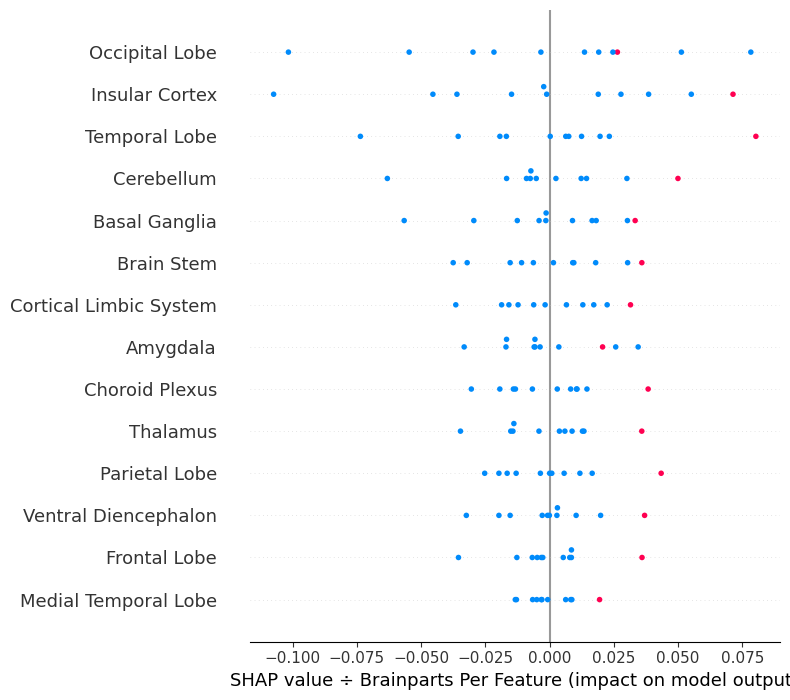

In [54]:
import shap
from sven import ApproxExplainerW
# note that unitsize can also be a tensor of the same shape as size_featvecs
exactv = ApproxExplainerW(fcn_model, dataset_test, torch.tensor(size_featvecs), unitsize=1664, method='binary_classification_1', device='cuda:1', num_to_sample=6000)
data_labels = torch.cat([dataset_test[:][1].unsqueeze(1) for _ in range(len(featurenames))], dim=1)
shap.summary_plot(exactv.shap_weighted.cpu().numpy(), data_labels.cpu().numpy(), feature_names=featurenames, max_display=100, color_bar=False, show=False)
plt.xlabel('SHAP value ÷ Brainparts Per Feature (impact on model output)')
plt.show()

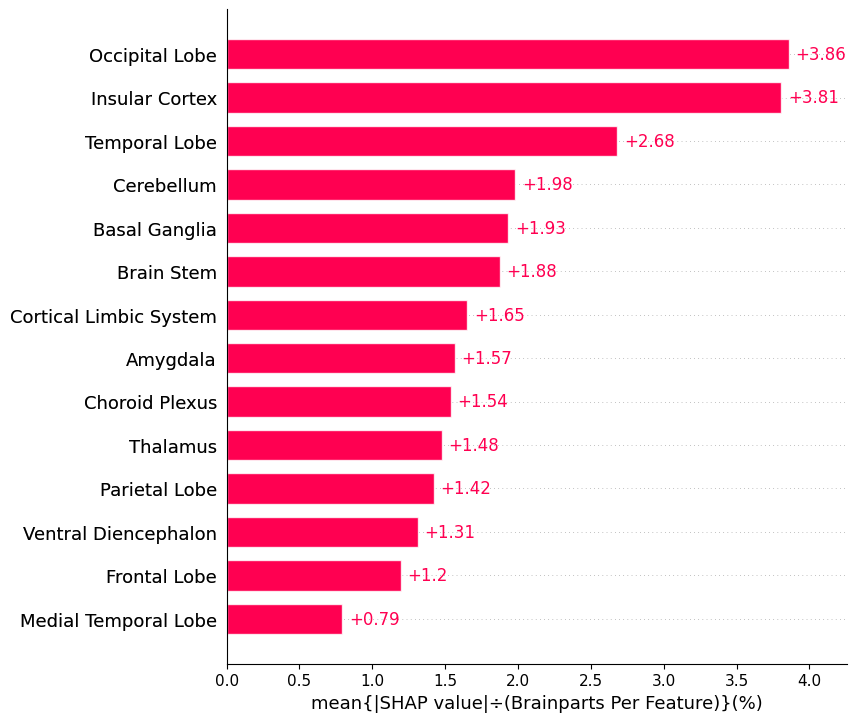

In [56]:
e = shap.Explanation((exactv.shap_weighted * 100).cpu().numpy(), feature_names=featurenames)
shap.plots.bar(e, max_display=100, show=False)
plt.xlabel('mean{|SHAP value|÷(Brainparts Per Feature)}(%)')
plt.show()